In [1]:
import time
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from IPython.display import HTML, display
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Patch
from tqdm import tqdm

display(HTML("<style>.container { width:100% !important; }</style>"))

# Generating the figure 2.
From the drug-gene co-occurence on attention coefficients, we search the paper on Pubmed.   
Then process it with DTI informaiton.   
The data is from [preprocess_for_fig2.ipynb](https://github.com/inoue0426/drGAT/blob/main/Figs/preprocess_for_fig2.ipynb)

In [2]:
df = pd.read_csv("result_all.csv")
df

,NSC,drug,gene,num,num in journals
0,740,METHOTREXATE,ATIC,58,44
1,740,METHOTREXATE,TYMS,65,0
2,740,METHOTREXATE,DHFR,300,210
3,740,METHOTREXATE,MIR330,0,0
4,740,METHOTREXATE,SNORD16,0,0
...,...,...,...,...,...
1340,791785,Sapacitabine,PGR,0,0
1341,791785,Sapacitabine,ZAP70,0,0
1342,791785,Sapacitabine,adenosine deaminase,0,0
1343,791785,Sapacitabine,EPHB6,0,0


In [3]:
np.sum(df["num"] != 0)

370

In [4]:
df["num"].sum()

10100

In [5]:
df["num in journals"].sum()

3264

In [6]:
n = dict(df[["NSC", "drug"]].values)
n

{740: 'METHOTREXATE',
 752: '6-THIOGUANINE',
 755: '6-MERCAPTOPURINE',
 762: 'Nitrogen mustard',
 1390: 'Allopurinol',
 1895: 'GUANAZOLE',
 3053: 'Actinomycin D',
 3088: 'Chlorambucil',
 6396: 'Thiotepa',
 8806: 'Melphalan',
 9706: 'Triethylenemelamine',
 14229: 'Acrichine',
 19893: 'Fluorouracil',
 24559: 'Mithramycin',
 25154: 'Pipobroman',
 26271: 'Cyclophosphamide',
 26980: 'Mitomycin',
 27640: 'Floxuridine',
 32065: 'Hydroxyurea',
 34462: 'Uracil mustard',
 38721: 'Mitotane',
 45388: 'DACARBAZINE',
 51143: 'Pyrazoloimidazole',
 56410: 'PORFIROMYCIN',
 63878: 'Cytarabine',
 63984: 'Cordycepin',
 71261: 'Beta-Thioguanine Deoxyriboside',
 71795: 'ELLIPTICINE',
 71851: 'A-TGdR',
 73754: 'Fluorodopan',
 77213: 'Procarbazine',
 79037: 'Lomustine',
 82151: 'Daunorubicin',
 83142: 'Daunorubicin',
 85998: 'STREPTOZOCIN',
 89201: 'Estramustine',
 94600: 'CAMPTOTHECIN',
 95382: 'Camptothecin Derivative',
 95441: 'METHYL CCNU',
 95466: 'PCNU',
 95678: '3-HP',
 100880: 'Camptothecin',
 102627:

In [7]:
df = df.sort_values("gene")
df

,NSC,drug,gene,num,num in journals
1135,753686,Olaparib,AKR1C3,1,1
1125,747856,Olaparib,AKR1C3,1,0
373,156303,M-AMSA,ALB,0,0
332,141540,Etoposide,ALB,10,0
1218,758230,Floxuridine,ALB,1,0
...,...,...,...,...,...
1083,736198,Indenoisoquinoline derivative,adenosine deaminase,0,0
653,355644,Anthrapyrazole derivative,adenosine deaminase,0,0
647,354646,Morpholinodoxorubicin,adenosine deaminase,0,0
884,643833,Camptothecin Derivative,adenosine deaminase,2,1


## Unique NSC

In [8]:
len(df["NSC"].unique())

269

# Alphabetical 

In [9]:
def get_small_size():
    bubble_data = df.groupby(["drug", "gene"])["num"].sum().reset_index()
    bubble_data = bubble_data.sort_values("gene")

    pivot_table_data = bubble_data.pivot_table(
        values="num", index="drug", columns="gene", aggfunc="sum"
    ).fillna(0)
    pivot_table_data.index = list(pivot_table_data.index)
    pivot_table_data.columns = list(pivot_table_data.columns)
    pivot_table_data = pivot_table_data.loc[bubble_data["drug"].unique()]
    pivot_table_data = pivot_table_data.sort_index()
    pivot_table_data.index = pivot_table_data.index.str.capitalize()
    pivot_table_data = pivot_table_data.groupby(pivot_table_data.index).mean()

    pivot_table_data.columns = [
        i.replace("adenosine deaminase", "ADA") for i in pivot_table_data.columns
    ]
    # pivot_table_data = pivot_table_data.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]
    pivot_table_data = pivot_table_data.loc[pivot_table_data.sum(axis=1) != 0]
    # pivot_table_data = pivot_table_data.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]
    pivot_table_data.index = (
        pivot_table_data.index.str.replace(
            "2-n-methyl-6-thiaellipticinum iodide", "NSC638066"
        )
        .str.replace("7-ethyl-10-hydroxycamptothecin", "NSC673596")
        .str.replace("6-mercaptopurine", "Mercaptopurine")
        .str.replace("6-thioguanine", "Thioguanine")
        .str.replace("8-chloro-adenosine", "NSC354258")
        .str.replace("Benzaldehyde (ben)", "Benzaldehyde")
    )
    pivot_table_data = pivot_table_data.loc[
        sorted(pivot_table_data.index), sorted(pivot_table_data.columns)
    ]

    t = pivot_table_data.copy()
    t = t * 0
    tmp = dti.loc[
        list(set(dti.index) & set(pivot_table_data.index)),
        list(set(dti.columns) & set(pivot_table_data.columns)),
    ]
    k = np.sign(tmp.groupby(tmp.index).sum())
    t.loc[tmp.index, tmp.columns] = k

    log_scale_data = np.log1p(
        pivot_table_data[(t.sum(axis=1) != 0) | (pivot_table_data.sum(axis=1) != 0)]
    )
    drugs = log_scale_data.index
    genes = log_scale_data.columns
    return drugs, genes

In [10]:
bubble_data = df.groupby(["drug", "gene"])["num"].sum().reset_index()
bubble_data.gene = bubble_data.gene.replace("adenosine deaminase", "ADA")
bubble_data = bubble_data.sort_values("gene")
bubble_data.drug = bubble_data.drug.str.capitalize()
bubble_data.drug = (
    bubble_data.drug.str.replace("2-n-methyl-6-thiaellipticinum iodide", "NSC638066")
    .str.replace("7-ethyl-10-hydroxycamptothecin", "NSC673596")
    .str.replace("6-mercaptopurine", "Mercaptopurine")
    .str.replace("6-thioguanine", "Thioguanine")
    .str.replace("8-chloro-adenosine", "NSC354258")
    .str.replace("Benzaldehyde (ben)", "Benzaldehyde")
)
bubble_data["existance"] = [1] * bubble_data.shape[0]
bubble_data = bubble_data.drop_duplicates()
bubble_data

,drug,gene,num,existance
806,Pyrazoloacridine,ADA,0,1
268,Cyclodisone,ADA,0,1
75,9-glycinamido-20(rs)-camptothecin hydrochloride,ADA,0,1
918,Uracil mustard,ADA,0,1
286,Camptothecin derivative,ADA,82,1
...,...,...,...,...
671,Mithramycin,ZAP70,0,1
658,Methoxycamptothecin,ZAP70,0,1
340,Cyanomorpholinodoxorubicin,ZAP70,0,1
697,Mitozolomide,ZAP70,0,1


# Unique Drugs and genes

In [11]:
len(bubble_data["drug"].unique())

162

In [12]:
len(bubble_data["gene"].unique())

134

## make a pivot table

In [13]:
pivot_table_data = bubble_data.pivot_table(
    values="num", index="drug", columns="gene", aggfunc="sum"
).fillna(0)
pivot_table_data.index = list(pivot_table_data.index)
pivot_table_data.columns = list(pivot_table_data.columns)
pivot_table_data = pivot_table_data.loc[bubble_data["drug"].unique()]
pivot_table_data = pivot_table_data.sort_index()
pivot_table_data = pivot_table_data.groupby(pivot_table_data.index).mean()
pivot_table_data

,ADA,AKR1C3,ALB,ALDH2,AR,ATIC,BLK,BMX,BTK,CA2,...,TLR8,TOP1,TOP1MT,TOP2A,TOP2B,TYMS,TYROBP,UGT1A1,XDH,ZAP70
"10,11-methylenedioxycamptothecin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10-aminocamptothecin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2-methylellpticinium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3-hp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-fluoro deoxy uridine 10mer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xr-11576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xr-5944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yoshi 864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zalcitabine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
existance = bubble_data.pivot_table(
    values="existance", index="drug", columns="gene", aggfunc="mean"
).fillna(0)
existance.index = list(existance.index)
existance.columns = list(existance.columns)
existance = existance.loc[bubble_data["drug"].unique()]
existance = existance.sort_index()
existance = existance.groupby(existance.index).mean()
existance

,ADA,AKR1C3,ALB,ALDH2,AR,ATIC,BLK,BMX,BTK,CA2,...,TLR8,TOP1,TOP1MT,TOP2A,TOP2B,TYMS,TYROBP,UGT1A1,XDH,ZAP70
"10,11-methylenedioxycamptothecin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10-aminocamptothecin,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2-methylellpticinium,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3-hp,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5-fluoro deoxy uridine 10mer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xr-11576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xr-5944,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Yoshi 864,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Zalcitabine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
cols = sorted(existance.columns)
idxs = sorted(existance.index)

In [16]:
pivot_table_data = pivot_table_data.loc[idxs, cols]
existance = existance.loc[idxs, cols]

In [17]:
name = dict(
    pd.read_csv("nsc_cid_smiles_class_name.csv", index_col=0)[["NSC", "NAME"]].values
)
dti = pd.read_csv("dti_drugbank.csv", index_col=0)
dti = np.sign(dti)
dti.index = [name[i] for i in dti.index]
dti.index = dti.index.str.capitalize()
dti = dti.loc[
    sorted(set(dti.index) & set(pivot_table_data.index)),
    sorted(set(dti.columns) & set(pivot_table_data.columns)),
]
dti = dti.drop_duplicates()

In [18]:
t = pivot_table_data.copy()
t = t * 0
t.loc[dti.index, dti.columns] = dti
t

,ADA,AKR1C3,ALB,ALDH2,AR,ATIC,BLK,BMX,BTK,CA2,...,TLR8,TOP1,TOP1MT,TOP2A,TOP2B,TYMS,TYROBP,UGT1A1,XDH,ZAP70
"10,11-methylenedioxycamptothecin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10-aminocamptothecin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2-methylellpticinium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3-hp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-fluoro deoxy uridine 10mer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xr-11576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xr-5944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yoshi 864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zalcitabine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
drugs, genes = get_small_size()

In [20]:
pivot_table_data.to_csv("pubchem.csv")

In [21]:
def create_comparison_matrix(predicted, known, drugs=None):
    # 結果のDataFrameを準備（既知のデータをコピーして使用）
    result = known.copy()
    for col in result.columns:
        result[col] = result[col].astype(str)  # 初期値の設定
        for idx in result.index:
            if predicted.at[idx, col] == 1 and known.at[idx, col] == 1:
                result.at[idx, col] = "♥"  # 予測も実際も1
            elif predicted.at[idx, col] == 1 and known.at[idx, col] == 0:
                result.at[idx, col] = "♣"  # 予測のみ1
            elif predicted.at[idx, col] == 0 and known.at[idx, col] == 1:
                result.at[idx, col] = "♦"  # 実際のみ1
            else:
                result.at[idx, col] = ""  # どちらも0

    if drugs is not None:
        result = result.loc[drugs]

    return result.values


# 比較マトリックスを生成
comparison_matrix = create_comparison_matrix(existance, t)

In [22]:
print("Both: " + str(np.sum(comparison_matrix == "♥")))
print(f"Only predicted: " + str(np.sum(comparison_matrix == "♣")))
print(f"Only dti: " + str(np.sum(comparison_matrix == "♦")))

Both: 64
Only predicted: 902
Only dti: 3


# Make a fig for overall results

Both: 64
Only predicted: 902
Only dti: 3


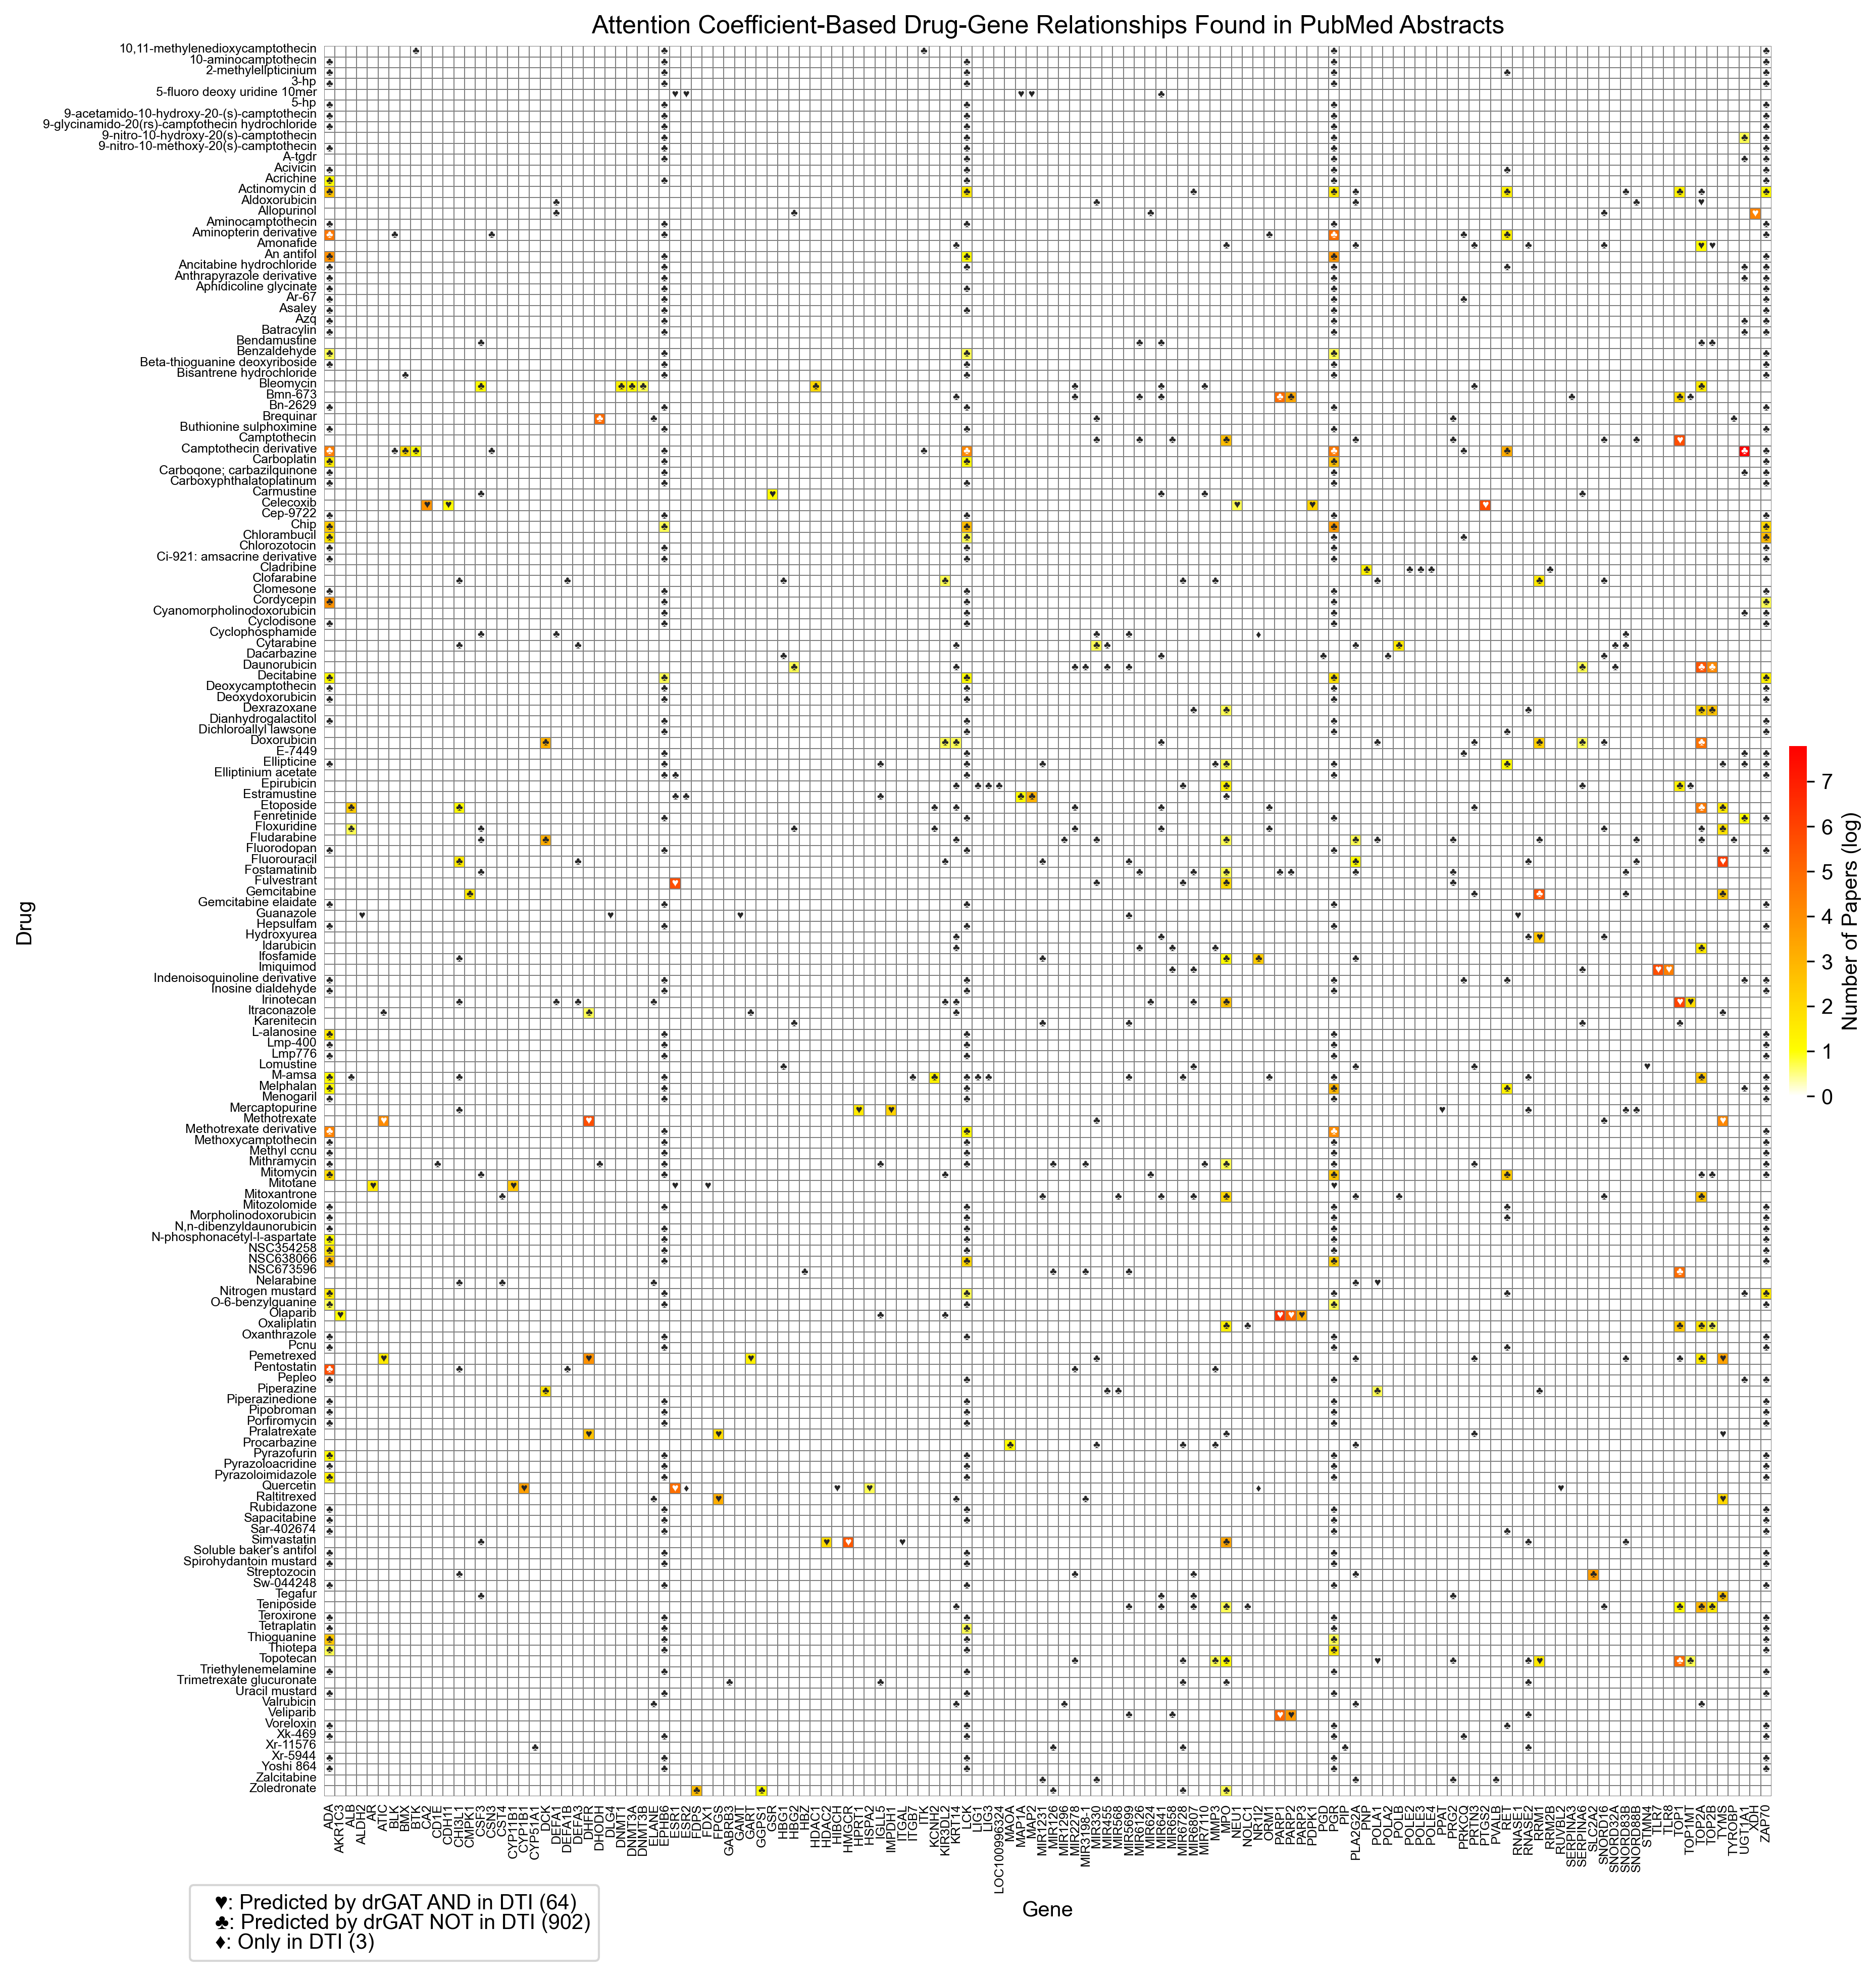

In [23]:
# Creating Heatmap without annotations (numbers)
plt.figure(figsize=(30, 15), dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

logged = np.log1p(pivot_table_data)

max_val = np.max(logged)
cmap = LinearSegmentedColormap.from_list(
    "Custom cmap", [(0, "white"), (1 / max_val, "yellow"), (1, "red")], N=256
)

both = str(np.sum(comparison_matrix == "♥"))
print("Both: " + both)
predict = str(np.sum(comparison_matrix == "♣"))
print(f"Only predicted: " + predict)
dti = str(np.sum(comparison_matrix == "♦"))
print(f"Only dti: " + dti)

# heatmap を描画
ax = sns.heatmap(
    logged,
    annot=comparison_matrix,
    fmt="",
    cmap=cmap,
    square=True,
    linewidths=0.1,
    cbar_kws={"label": "Number of Papers (log)", "shrink": 0.2, "pad": 0.005},
    linecolor="gray",
    annot_kws={
        #         'color': 'black',
        "size": 5
    },
)

ax.set_xticks(np.arange(pivot_table_data.shape[1]))
ax.set_yticks(np.arange(pivot_table_data.shape[0]))

y_ticks_positions = [tick + 0.3 for tick in ax.get_yticks()]  # Adjust 0.3 as needed
ax.set_yticks(y_ticks_positions)

ax.set_xticklabels(pivot_table_data.columns)
ax.set_yticklabels(pivot_table_data.index)

ax.tick_params(axis="x", which="major", labelsize=6, length=0)
ax.tick_params(axis="y", which="major", labelsize=6, length=0)

# Adding a legend
legend_elements = [
    Patch(
        facecolor="none",
        edgecolor="none",
        label=f"♥: Predicted by drGAT AND in DTI ({both})",
    ),
    Patch(
        facecolor="none",
        edgecolor="none",
        label=f"♣: Predicted by drGAT NOT in DTI ({predict})",
    ),
    Patch(facecolor="none", edgecolor="none", label=f"♦: Only in DTI ({dti})"),
]
ax.legend(
    handles=legend_elements,
    loc="lower left",
    bbox_to_anchor=(-0.1, -0.1),
    frameon=True,
    handlelength=0,
    handleheight=0,
    labelspacing=0,
    fontsize=10,
)


plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.xlabel("Gene")
plt.ylabel("Drug")
plt.title(
    "Attention Coefficient-Based Drug-Gene Relationships Found in PubMed Abstracts"
)
plt.savefig("output_all.pdf")
plt.show()

In [24]:
matrix1 = logged.values != 0
matrix1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [25]:
matrix2 = comparison_matrix == "♣"
matrix2

array([[False, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       ...,
       [ True, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [26]:
result = np.logical_and(matrix1, matrix2)
result

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [27]:
true_count = np.sum(result)
print(f"Predicted DTIs which have PubMed abstract: {true_count}")

Predicted DTIs which have PubMed abstract: 156


# Smaller version
- Choose drugs which have at least 1 PubMed
- Choose genes which have at least 1 Co-occurence after ↑ preprocess

Both: 48
Only predicted: 331
Only dti: 1


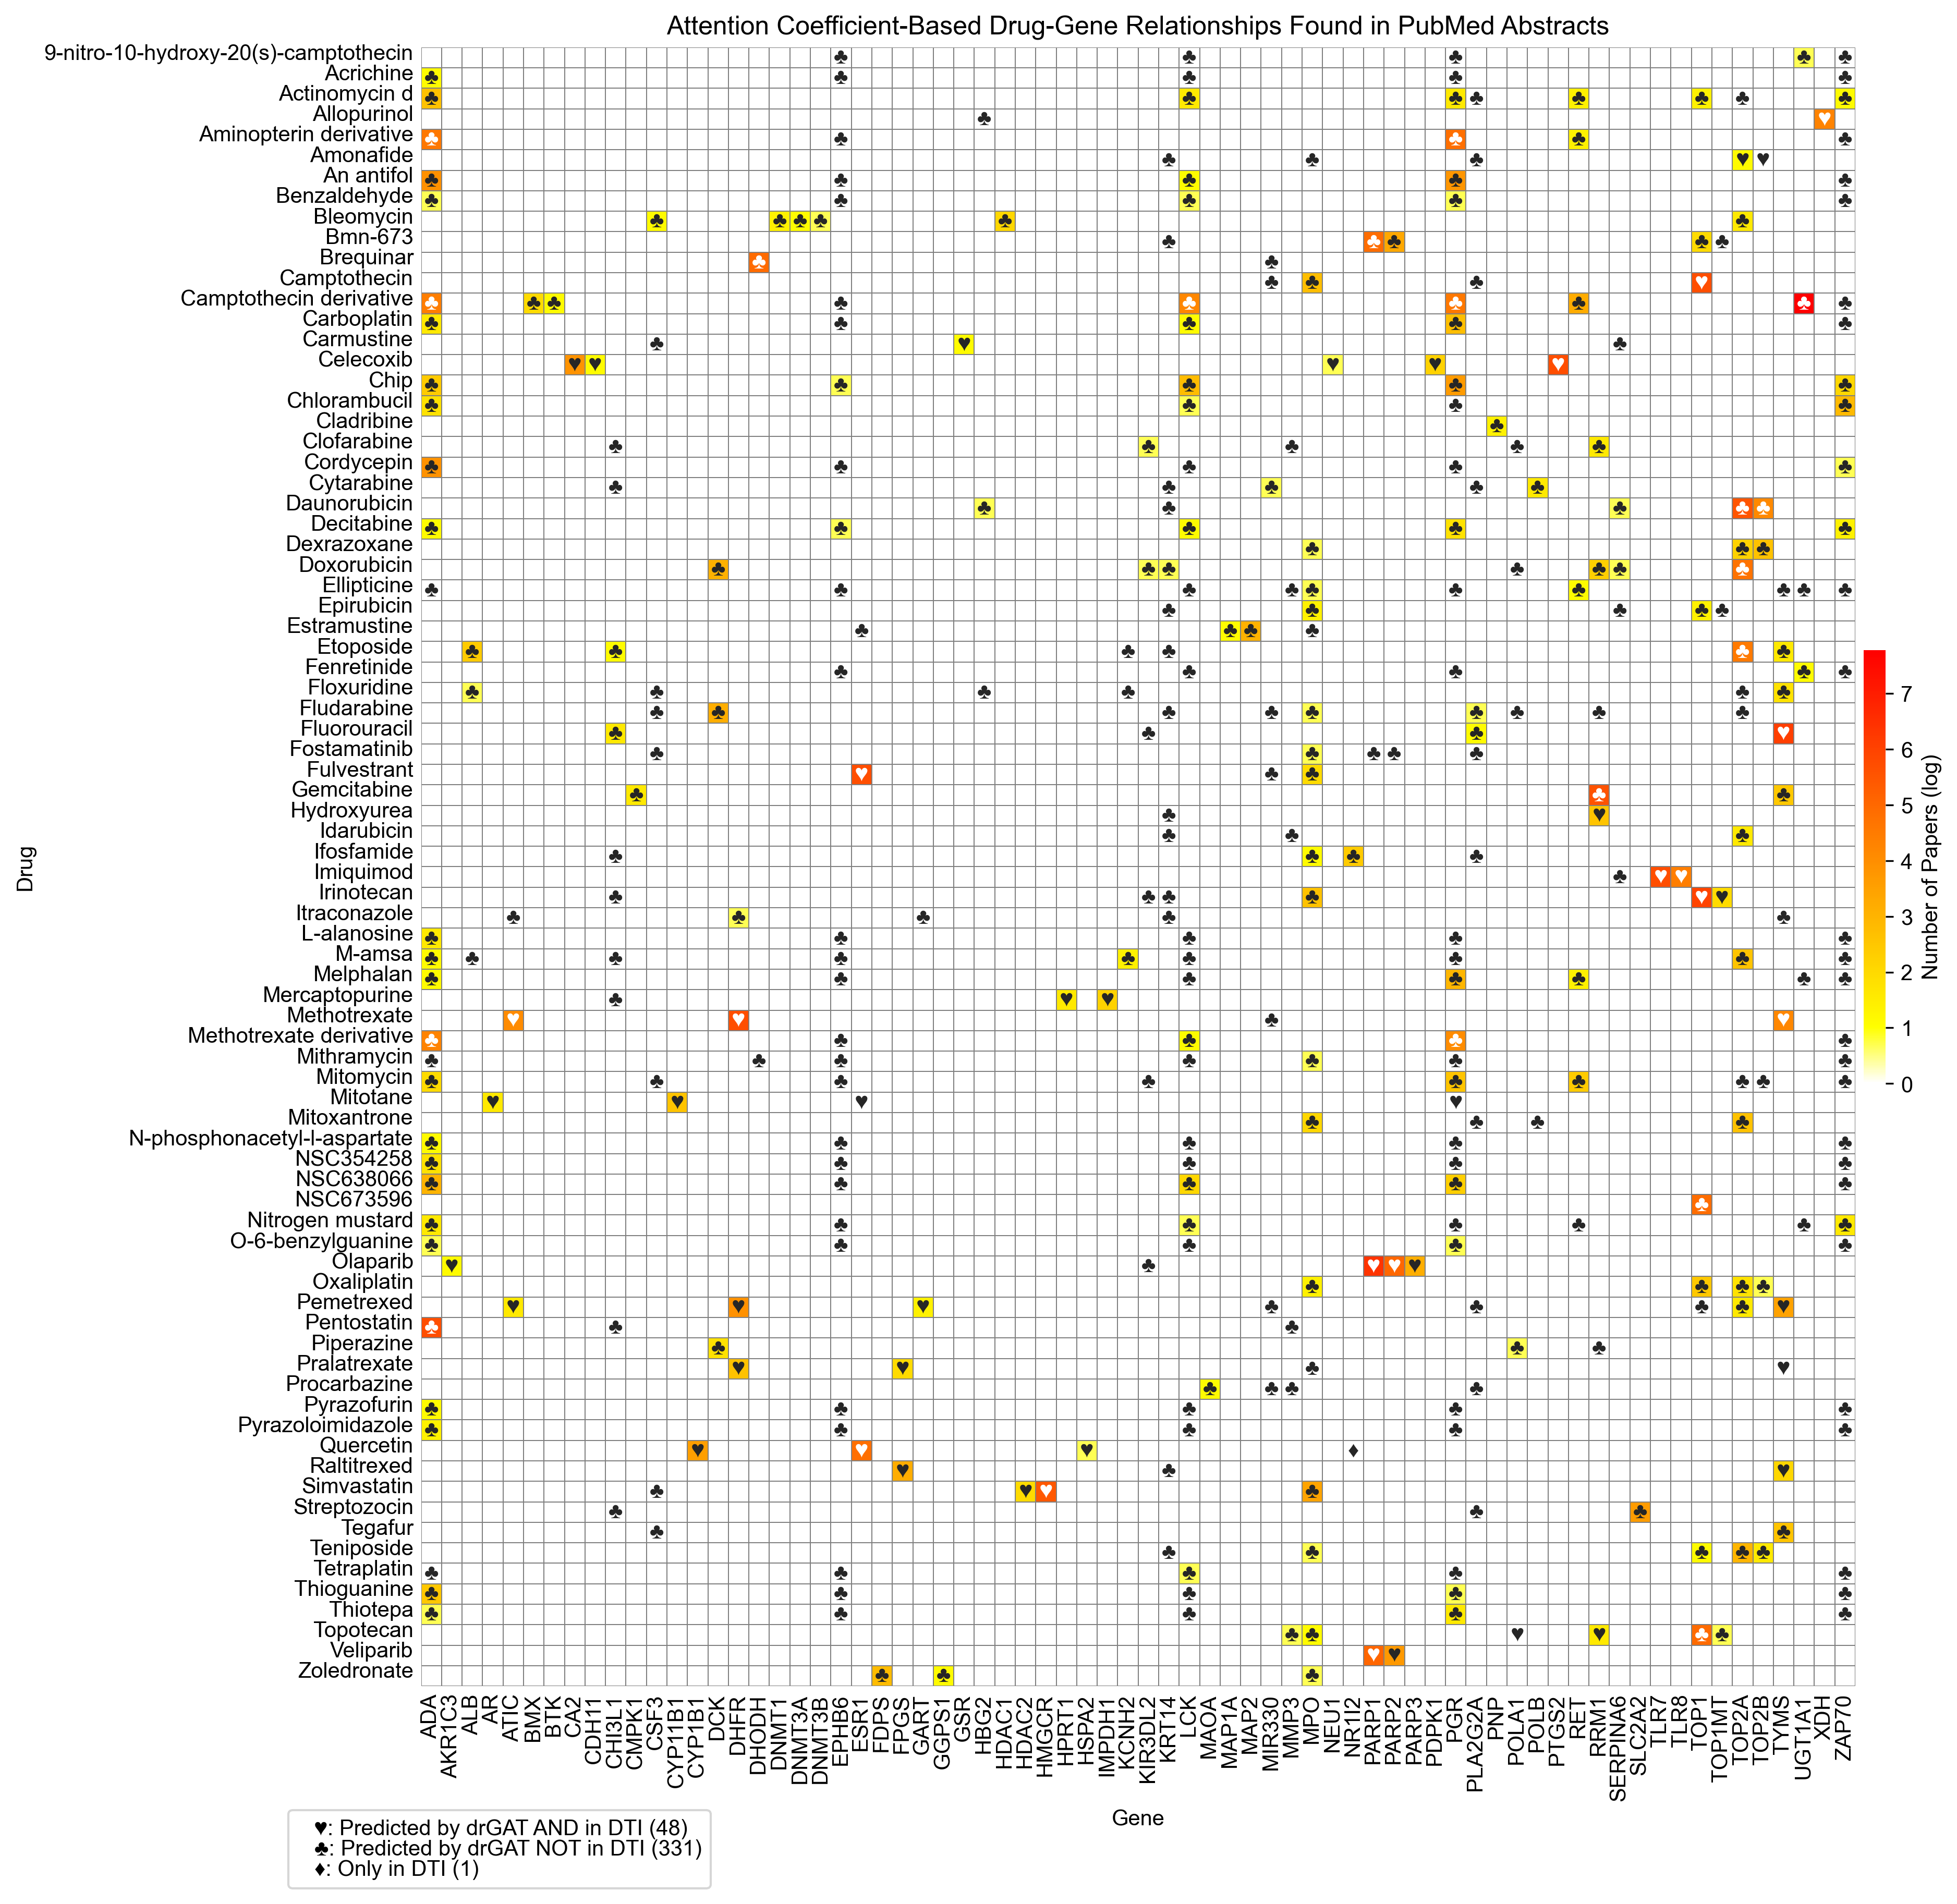

In [28]:
# Creating Heatmap without annotations (numbers)
plt.figure(figsize=(14, 18), dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.size"] = 10

logged = np.log1p(pivot_table_data.loc[drugs])
comparison_matrix = create_comparison_matrix(existance, t, drugs)

tmp = logged.sum()
tmp = tmp[tmp != 0]
comparison_matrix = pd.DataFrame(comparison_matrix, columns=logged.columns)
logged = logged.loc[:, tmp.index]
comparison_matrix = comparison_matrix.loc[:, tmp.index].values

both = str(np.sum(comparison_matrix == "♥"))
print("Both: " + both)
predict = str(np.sum(comparison_matrix == "♣"))
print(f"Only predicted: " + predict)
dti = str(np.sum(comparison_matrix == "♦"))
print(f"Only dti: " + dti)

max_val = np.max(logged)
cmap = LinearSegmentedColormap.from_list(
    "Custom cmap", [(0, "white"), (1 / max_val, "yellow"), (1, "red")], N=256
)

# heatmap を描画
ax = sns.heatmap(
    logged,
    annot=comparison_matrix,
    fmt="",
    cmap=cmap,
    square=True,
    linewidths=0.1,
    cbar_kws={"label": "Number of Papers (log)", "shrink": 0.2, "pad": 0.005},
    linecolor="gray",
    #     annot_kws={
    #         #         'color': 'black',
    #         "size": 5
    #     },
)

ax.set_xticks(np.arange(logged.shape[1]))
ax.set_yticks(np.arange(logged.shape[0]))

y_ticks_positions = [tick + 0.3 for tick in ax.get_yticks()]  # Adjust 0.3 as needed
ax.set_yticks(y_ticks_positions)

ax.set_xticklabels(logged.columns)
ax.set_yticklabels(logged.index)

ax.tick_params(axis="x", which="major", length=0)
ax.tick_params(axis="y", which="major", length=0)

# Adding a legend
legend_elements = [
    Patch(
        facecolor="none",
        edgecolor="none",
        label=f"♥: Predicted by drGAT AND in DTI ({both})",
    ),
    Patch(
        facecolor="none",
        edgecolor="none",
        label=f"♣: Predicted by drGAT NOT in DTI ({predict})",
    ),
    Patch(facecolor="none", edgecolor="none", label=f"♦: Only in DTI ({dti})"),
]
ax.legend(
    handles=legend_elements,
    loc="lower left",
    bbox_to_anchor=(-0.1, -0.13),
    frameon=True,
    handlelength=0,
    handleheight=0,
    labelspacing=0,
)

plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.xlabel("Gene")
plt.ylabel("Drug")
plt.title(
    "Attention Coefficient-Based Drug-Gene Relationships Found in PubMed Abstracts"
)
plt.savefig("fig2.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [29]:
logged

,ADA,AKR1C3,ALB,AR,ATIC,BMX,BTK,CA2,CDH11,CHI3L1,...,TLR7,TLR8,TOP1,TOP1MT,TOP2A,TOP2B,TYMS,UGT1A1,XDH,ZAP70
9-nitro-10-hydroxy-20(s)-camptothecin,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.693147,0.000000,0.000000
Acrichine,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
Actinomycin d,2.639057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.386294,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.098612
Allopurinol,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,4.290459,0.000000
Aminopterin derivative,4.574711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thioguanine,2.484907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
Thiotepa,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
Topotecan,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.934474,0.693147,0.0,0.0,0.0,0.000000,0.000000,0.000000
Veliparib,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [30]:
matrix1 = logged.values != 0
matrix1

array([[False, False, False, ...,  True, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [31]:
matrix2 = comparison_matrix == "♣"
matrix2

array([[False, False, False, ...,  True, False,  True],
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [32]:
result = np.logical_and(matrix1, matrix2)
result

array([[False, False, False, ...,  True, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [33]:
true_count = np.sum(result)
print(f"Predicted DTIs which have PubMed abstract: {true_count}")

Predicted DTIs which have PubMed abstract: 156


In [34]:
matrix1.shape

(80, 70)

In [35]:
matrix2.shape

(80, 70)

In [36]:
logged != 0

,ADA,AKR1C3,ALB,AR,ATIC,BMX,BTK,CA2,CDH11,CHI3L1,...,TLR7,TLR8,TOP1,TOP1MT,TOP2A,TOP2B,TYMS,UGT1A1,XDH,ZAP70
9-nitro-10-hydroxy-20(s)-camptothecin,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
Acrichine,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Actinomycin d,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
Allopurinol,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
Aminopterin derivative,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thioguanine,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Thiotepa,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Topotecan,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
Veliparib,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
